# Neural Networks for image classification

### importing libraries

In [14]:
import keras
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Flatten,Lambda,Reshape,Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,multiply,concatenate,Convolution2D
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers
from keras.constraints import Constraint
from keras import backend as K
from keras.layers import Activation
from keras.callbacks import callbacks 
from keras.callbacks import ModelCheckpoint

import random
import os
import numpy as np
from matplotlib import pyplot as plt
from progressbar import ProgressBar
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss

### Setting up data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [2]:
batch_size = 40
epochs = 12
img_rows, img_cols = 32, 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


X = np.reshape(np.vstack([x_train,x_test]),(-1,img_rows,img_cols,3))
Y = np.reshape(np.vstack([y_train,y_test]),(-1,1))

In [4]:
x_train = np.array(x_train).reshape(-1,img_rows,img_cols,3) - np.mean(X,axis = 0)
x_test = np.array(x_test).reshape(-1,img_rows,img_cols,3) - np.mean(X,axis = 0)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [5]:
print (np.shape(x_train))
print (np.shape(x_test))
print (np.shape(y_train))
print (np.shape(y_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


### Helper functions:
<br> Batching : each batch contains <batch_size> number of points sampled from train data(samples and labels)
<br> calc_acc: gives accuracy on test data given a model
<br> get_model: returns an mlp 
<br> compile_model: returns a compiled model given an architecture

In [6]:
def batch(batch_size, x = x_train, y = y_train):
    samples = np.array(random.sample(range(1, len(x)), batch_size))
    return x[samples],y[samples]

In [7]:
def calc_acc(model,x_test = x_test, y_test = y_test):
    s1 = np.argmax(model.predict(x_test),axis=1)
    s2 = np.argmax(y_test,axis=1)
    c = 0
    for i in range(len(s1)):
        if s1[i] == s2[i]:
            c +=1
    return (c/np.shape(x_test)[0])*100

In [18]:
def get_model():
    input_l = Input(shape=(32, 32, 3,))
    lay1_1 = Convolution2D(96, (3, 3), padding = 'same',activation='relu')(input_l)
    lay1_2 = Convolution2D(96, (3, 3), padding = 'same',activation='relu')(lay1_1)
    lay1_2 = Dropout(0.5)(lay1_2)
    norm_1 = BatchNormalization()(lay1_2)
    lay1_3 = Convolution2D(96, (3, 3), padding = 'same',activation='relu', subsample = (2,2))(norm_1)
    flat = Flatten()(lay1_3)
    out = Dense(10, activation='softmax',kernel_initializer='glorot_uniform')(flat)
    model = Model(inputs=[input_l], outputs=[out])
    return model

In [19]:
def compile_model(model):
    sgd = optimizers.SGD(lr=0.001, momentum=0.9, clipnorm=1.0, clipvalue=0.5)
    model.compile(optimizer=keras.optimizers.Adam(lr = 0.0001) ,loss=keras.losses.categorical_crossentropy,metrics = ['accuracy'])
    return model

In [20]:
model = get_model()

/home/u980159/anaconda3/envs/my_space/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same", activation="relu", strides=(2, 2))`
  import sys


### Model summary

In [21]:
model = compile_model(model)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
flatten_2 (Flatten)          (None, 24576)             0   

### Training

In [22]:
no_of_epochs = 15
history_c = model.fit(x_train, y_train,  batch_size=batch_size, epochs=no_of_epochs,validation_data=(x_test, y_test), verbose=1)


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 28s 558us/step - loss: 1.6053 - accuracy: 0.4329 - val_loss: 1.2234 - val_accuracy: 0.5597
Epoch 2/15
50000/50000 [==============================] - 26s 528us/step - loss: 1.1904 - accuracy: 0.5825 - val_loss: 1.0250 - val_accuracy: 0.6331
Epoch 3/15
50000/50000 [==============================] - 26s 530us/step - loss: 0.9965 - accuracy: 0.6516 - val_loss: 0.9510 - val_accuracy: 0.6680
Epoch 4/15
50000/50000 [==============================] - 27s 530us/step - loss: 0.8725 - accuracy: 0.6947 - val_loss: 0.9250 - val_accuracy: 0.6827
Epoch 5/15
50000/50000 [==============================] - 27s 532us/step - loss: 0.7915 - accuracy: 0.7248 - val_loss: 0.8917 - val_accuracy: 0.6941
Epoch 6/15
50000/50000 [==============================] - 27s 532us/step - loss: 0.7281 - accuracy: 0.7469 - val_loss: 0.8877 - val_accuracy: 0.6996
Epoch 7/15
50000/50000 [==============================]

### Analysis

In [2]:
b_l = history_c.history['val_loss']
v_l = history_c.history['loss']
acc_t = history_c.history['val_accuracy']
acc_tr = history_c.history['accuracy']

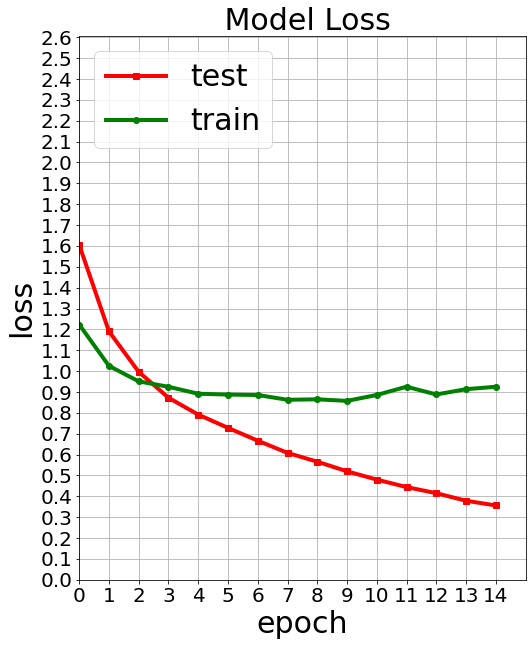

In [25]:
fig = plt.figure(figsize=(8,10))
plt.xlim(0, no_of_epochs)
plt.ylim(0, np.max(v_l)+1)

ax = fig.gca()
ax.set_xticks(np.arange(0, no_of_epochs, 1))
ax.set_yticks(np.arange(0, np.max(v_l)+1, 0.1))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

plt.plot(v_l[:no_of_epochs],'r-s' ,linewidth=4)
plt.plot(b_l[:no_of_epochs],'g-o',linewidth=4)
plt.grid()

plt.title(' Model Loss',fontsize=30)
plt.ylabel('loss',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['test', 'train'], loc='upper left', prop={"size":30})
plt.show()

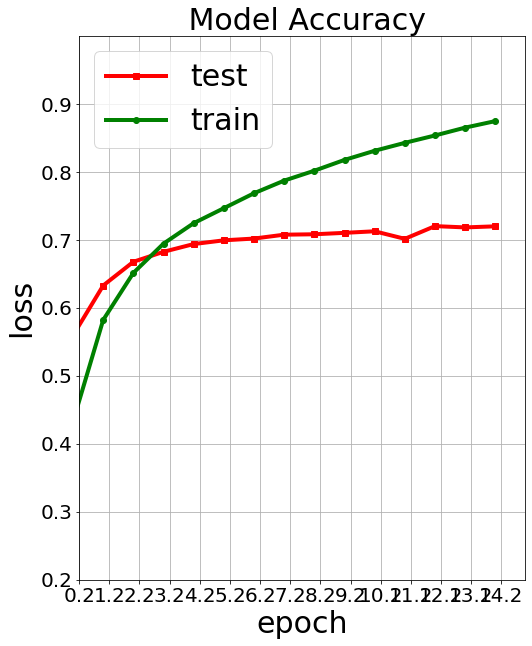

In [26]:
fig = plt.figure(figsize=(8,10))
plt.xlim(0.2, no_of_epochs)
plt.ylim(0.2, 1)

ax = fig.gca()
ax.set_xticks(np.arange(0.2, no_of_epochs, 1))
ax.set_yticks(np.arange(0.2, 1, 0.1))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

plt.plot(acc_t[:no_of_epochs],'r-s' ,linewidth=4)
plt.plot(acc_tr[:no_of_epochs],'g-o',linewidth=4)
plt.grid()

plt.title(' Model Accuracy',fontsize=30)
plt.ylabel('loss',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['test', 'train'], loc='upper left', prop={"size":30})
plt.show()

In [27]:
print (calc_acc(model))
print (calc_acc(model=model,x_test=x_train,y_test=y_train))        

72.02
94.746


In [28]:
labels = ['airplane',
'automobile', 
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck']

In [29]:
s1 = np.argmax(model.predict(x_test),axis=1)
s2 = np.argmax(y_test,axis=1)
c = []
pr_l = []
for i in range(len(s1)):
    if not s1[i] == s2[i]:
        c.append(i)
    pr_l.append("Label = "+labels[s2[i]]+"  Predicted_Label = "+labels[s1[i]])

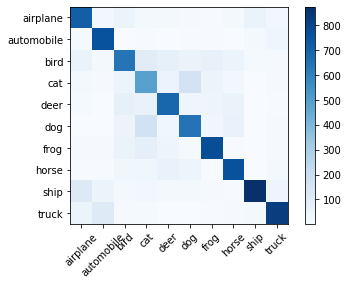

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(s1,s2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.show()

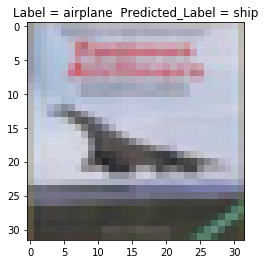

In [31]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
for i,ele in enumerate(x_test[:100]):
    if i in c:
        plot_var = ele
        plt.imshow(plot_var)
        plt.title(pr_l[i])
        plt.show()
        break

In [32]:
model.save_weights('CNN.h5')